In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

### Загрузим датасет с машинами. Цель - верно восстанавливать для каждой из них цену продажи!

In [160]:
data = pd.read_csv('autos.csv')

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [161]:
### Колонка с тергетом - "selling price"

X = data.drop("selling_price", axis=1)
y = data["selling_price"]

### Будем замерять MSLE!
### Поэтому прологарифмируем таргет
### А после оптимизируем MSE

y = y.apply(np.log1p)

In [162]:
### Разделим выборку на трейн и тест!

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

__Задание__ 

Реализуйте свой MeanTargetEncoder с добавленем некоторого шума!

Однажды в лекционном материале, обсуждая счетчики, мы говорили с вами о том, что из-за них модели могут переобучаться. Один из способов бороться с этим - валидировать расчеты среднего таргета (стратегия отложенной выборки / расчеты на кросс-валидации). Но есть еще проще!

Можно просто к значению счетчика добавить случайный шум (зашумить данные)!

Напомним, что рассчитываться новые признаки должны по такой формуле:

$$
g_j = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}{l} + C * \epsilon
$$


Пусть шум будет случайной величиной из нормального стандартного распределения, то есть $\epsilon \sim N(0, 1) $, а $ C = 0.006$.

Создавай свой класс-трансформер, наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`. Трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. 
Ваш трансформер должен принимать при инициализации список из категориальных признаков и список из числовых признаков. 

Если для какого-то признака в тестовой выборке отсутствует значение, трансформер должен поставить там 0.

На выходе должен получиться датасет того же размера с измененными категориальными признаками

In [163]:
object_cols = ['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols = ['km_driven']

X.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner


In [164]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical, numeric):
        self.categorical = categorical
        self.numeric = numeric
        self.mean_target = {} # Словарь для хранения значений Mean Target для каждого категориального признака и каждого числового признака
        self.C = 0.006
    
    def fit(self, X, y):
        """
        Метод fit для расчета Mean Target для каждого категориального и числового признака.
        Расчет проводится только по обучающей выборке.
        :param X: pandas.DataFrame, обучающая выборка
        :param y: pandas.Series, значения целевой переменной для обучающей выборки
        :return: экземпляр класса MeanTargetEncoderNoise
        """
        for col in self.categorical:
            df = pd.DataFrame({'feature': X[col], 'target': y}) # Создаем DataFrame, чтобы сгруппировать значения по признаку
            mean_target = df.groupby(['feature'])['target'].mean() # Считаем среднее значение target для каждого значения признака
            self.mean_target[col] = mean_target  # Добавляем значения mean target в словарь
        
        for col in self.numeric:
            self.mean_target[col] = y.mean() # Для числовых признаков считаем среднее значение target по всей выборке
            
            return self
        
    def transform(self, X):
        """
        Метод transform для трансформации признаков с помощью Mean Target Encoding с добавлением шума.
        :param X: pandas.DataFrame, выборка для трансформации
        :return: pandas.DataFrame, трансформированная выборка
        """
        temp = X.copy()  # Создаем копию датасета, чтобы не изменять исходные данные
        
        for col in self.categorical:
            temp[col] = temp[col].map(self.mean_target[col]) # Заменяем значения категориального признака на значения mean target
            temp[col] = temp[col] + self.C * np.random.randn(len(X)) # Добавляем случайный шум
            temp[col] = temp[col].fillna(0) # Заполняем пропущенные значения 0
            
        for col in self.numeric:
            temp[col] = temp[col].fillna(self.mean_target[col]) # Заполняем пропущенные значения средним значением target по всей выборке
            
        return temp

In [165]:
### Проверка работы трансформера

np.random.seed(1)
transformer = MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)

transformer.fit(X_train, y_train)

train = transformer.transform(X_train)
test = transformer.transform(X_test)

train.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
3294,13.478865,13.430921,50000,13.088541,12.609423,13.759065,12.964161
2290,12.111783,11.901925,70000,12.457036,12.620399,13.777324,12.962823
874,12.298593,13.336935,50000,12.455670,12.616451,12.645775,12.984195
1907,12.477658,13.055335,92198,12.463101,13.152012,12.637086,12.452642
3244,12.397144,12.857059,3240,12.454647,12.614863,12.627399,12.471970


Обучите несколько деревьев, перебирая максимальную глубину алгоритма из списка `max_depth_list`, а остальные параметры оставьте дефолтными. Выведите лучшее значение гиперпараметра. Постройте график зависимости MSLE на тестовой выборке от значения гиперпараметра. Воспользуйтесь `Pipeline` без `GridSearch`. Проделайте то же самое с `min_samples_split`, `min_impurity_decrease`, `max_leaf_nodes`. (по 2б на каждый параметр)

In [166]:
max_depth_list = [3, 5, 8, 12]
min_samples_split_list = [10, 50, 100, 500]
min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
max_leaf_nodes_list = [100, 200, 500]

In [167]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt

In [168]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

np.random.seed(1)
### Your code is here
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

max_depth_list = [1,2,3,4, 5, 8, 12]
result_test = {}
result_train = {}
for col in max_depth_list:
    pipe = Pipeline([("custom_transformer",
                   MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                  
                  
                 ("decision_tree", 
                  DecisionTreeRegressor(max_depth=col))])

    pipe.fit(X_train, y_train)

    mse_train =mse(y_train, pipe.predict(X_train))
    mse_test = mse(y_test, pipe.predict(X_test))
    max_depth = f'max_depth_{col}'
    result_test.update({max_depth:mse_test})
    result_train.update({max_depth:mse_train})

result_test



{'max_depth_1': 0.5212834985456157,
 'max_depth_2': 0.626720708557684,
 'max_depth_3': 0.7861836137784873,
 'max_depth_4': 0.9844293563424611,
 'max_depth_5': 1.4423379879439593,
 'max_depth_8': 1.45617182464722,
 'max_depth_12': 1.59276610655452}

In [169]:
def find_best_hyperparameter(hyperparameter_name, hyperparameter_values, X_train, y_train, X_test, y_test):
    msle_scores = []

    for value in hyperparameter_values:
        # Создайте и настройте объект Pipeline
        pipeline = Pipeline([
            ('encoder', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
            ('model', DecisionTreeRegressor(**{hyperparameter_name: value})) # ** - распаковка словаря
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        msle_train = mean_squared_log_error(y_train, pipeline.predict(X_train))
        msle_test = mean_squared_log_error(y_test, y_pred)
        mle_test = mean_squared_error(y_test, y_pred)
        
        print(f"Значение {hyperparameter_name}: {value}")
        print(f"MSLE на тесте: {round(msle_test, 3)}")
        
        # MSE на тесте
        print(f"MSE на тесте: {round(mse(y_test, y_pred), 3)}")
        
        msle_scores.append(msle_test)
        

    # Постройте график
    plt.plot(hyperparameter_values, msle_scores)
    plt.xlabel(hyperparameter_name)
    plt.ylabel('MSLE')
    plt.title(f'MSLE vs {hyperparameter_name}')
    plt.show()

    # Найдите и верните лучшее значение гиперпараметра
    best_value = hyperparameter_values[np.argmin(msle_scores)]
    
    #!!! переписываем на MSE
    best_value = hyperparameter_values[np.argmin(m
    print(f"Лучшее значение {hyperparameter_name}: {best_value}")
    # лучшее MLSE, округленное до 3 знаков после запятой
    print(f"Лучшее MLSE: {round(min(msle_scores), 3)}")
    print(f"Лучшее MSE: {round(mse(y_test, pipeline.predict(X_test)), 3)}")

    return best_value


Значение max_depth: 1
MSLE на тесте: 0.003
MSE на тесте: 0.521
Значение max_depth: 2
MSLE на тесте: 0.003
MSE на тесте: 0.625
Значение max_depth: 3
MSLE на тесте: 0.004
MSE на тесте: 0.793
Значение max_depth: 4
MSLE на тесте: 0.006
MSE на тесте: 0.991
Значение max_depth: 5
MSLE на тесте: 0.009
MSE на тесте: 1.439
Значение max_depth: 8
MSLE на тесте: 0.013
MSE на тесте: 1.99
Значение max_depth: 12
MSLE на тесте: 0.01
MSE на тесте: 1.634


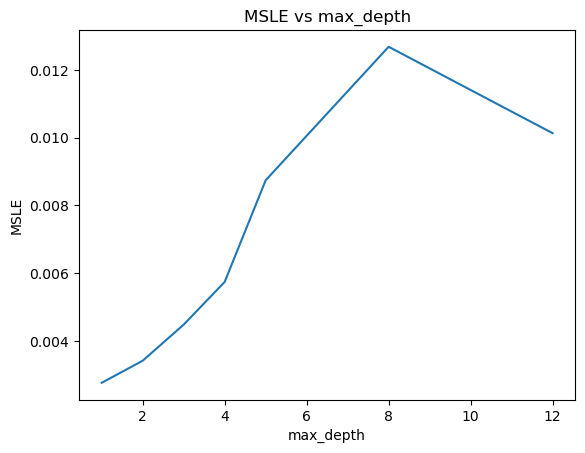

Лучшее значение max_depth: 1
Лучшее MLSE: 0.003
Лучшее MSE: 1.6


In [170]:
best_max_depth = find_best_hyperparameter('max_depth', max_depth_list, X_train, y_train, X_test, y_test)

Значение min_samples_split: 10
MSLE на тесте: 0.009
MSE на тесте: 1.45
Значение min_samples_split: 50
MSLE на тесте: 0.009
MSE на тесте: 1.443
Значение min_samples_split: 100
MSLE на тесте: 0.006
MSE на тесте: 0.994
Значение min_samples_split: 500
MSLE на тесте: 0.005
MSE на тесте: 0.818


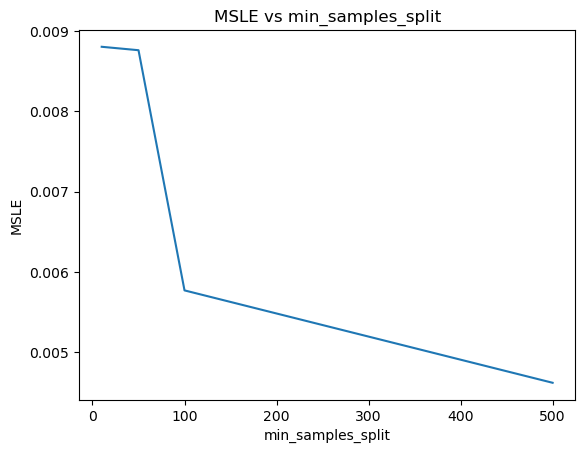

Лучшее значение min_samples_split: 500
Лучшее MLSE: 0.005
Лучшее MSE: 0.82


In [171]:
best_min_samples_split = find_best_hyperparameter('min_samples_split', min_samples_split_list, X_train, y_train, X_test, y_test)

Значение min_impurity_decrease: 0
MSLE на тесте: 0.013
MSE на тесте: 2.011
Значение min_impurity_decrease: 0.1
MSLE на тесте: 0.003
MSE на тесте: 0.526
Значение min_impurity_decrease: 0.15
MSLE на тесте: 0.003
MSE на тесте: 0.528
Значение min_impurity_decrease: 0.2
MSLE на тесте: 0.003
MSE на тесте: 0.527


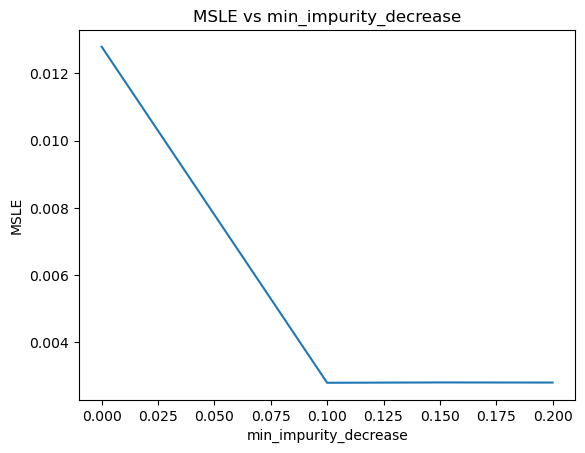

Лучшее значение min_impurity_decrease: 0.1
Лучшее MLSE: 0.003
Лучшее MSE: 0.526


In [172]:
est_min_impurity_decrease = find_best_hyperparameter('min_impurity_decrease', min_impurity_decrease_list, X_train, y_train, X_test, y_test)

Значение max_leaf_nodes: 100
MSLE на тесте: 0.009
MSE на тесте: 1.436
Значение max_leaf_nodes: 200
MSLE на тесте: 0.013
MSE на тесте: 1.993
Значение max_leaf_nodes: 500
MSLE на тесте: 0.009
MSE на тесте: 1.521


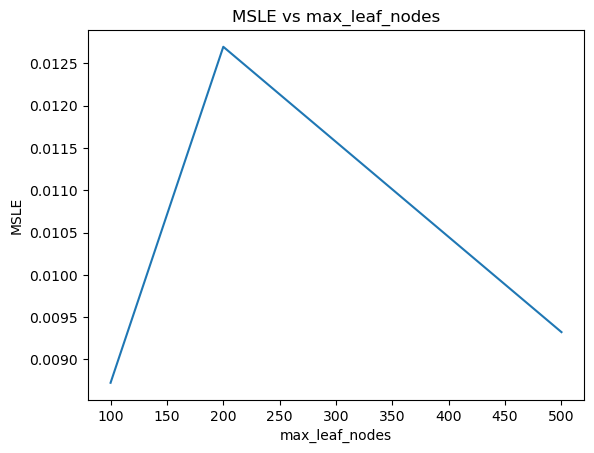

Лучшее значение max_leaf_nodes: 100
Лучшее MLSE: 0.009
Лучшее MSE: 1.556


In [173]:
best_max_leaf_nodes = find_best_hyperparameter('max_leaf_nodes', max_leaf_nodes_list, X_train, y_train, X_test, y_test)

Значение min_impurity_decrease: 0
MSLE на тесте: 0.012
MSE на тесте: 1.896
Значение min_impurity_decrease: 0.1
MSLE на тесте: 0.003
MSE на тесте: 0.524
Значение min_impurity_decrease: 0.15
MSLE на тесте: 0.003
MSE на тесте: 0.52
Значение min_impurity_decrease: 0.2
MSLE на тесте: 0.003
MSE на тесте: 0.524


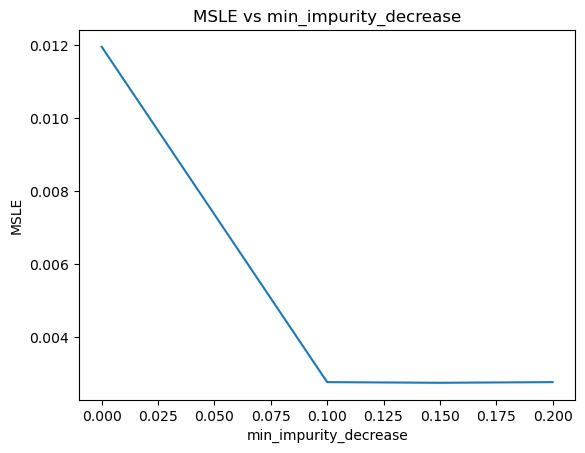

Лучшее значение min_impurity_decrease: 0.15
Лучшее MLSE: 0.003
Лучшее MSE: 0.521


In [174]:
best_min_impurity_decrease = find_best_hyperparameter('min_impurity_decrease', min_impurity_decrease_list, X_train, y_train, X_test, y_test)

In [ ]:
### Лучшие гиперпараметры

fig = plt.figure(figsize=(10, 10))
i = 1

for mse

In [176]:
from sklearn.metrics import mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

np.random.seed(1)

pipe = Pipeline([
    ("encoder", MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
    ("model", DecisionTreeRegressor(max_depth=best_max_depth, min_samples_split=best_min_samples_split, min_impurity_decrease=best_min_impurity_decrease, max_leaf_nodes=best_max_leaf_nodes))
])

pipe.fit(X_train, y_train)

print(f"MSLE на тесте: {round(mean_squared_log_error(y_test, pipe.predict(X_test)), 3)}")
print(f"MSE на тесте: {round(mse(y_test, pipe.predict(X_test)), 3)}")

MSLE на тесте: 0.003
MSE на тесте: 0.521


Подберите лучшую комбинацию параметров, используя `GridSearchCV` и набор массивов значений параметров из предыдущего задания. Для лучшей комбинации посчитайте MSLE на тестовой выборке. Получились ли лучшие параметры такими же, как если бы вы подбирали их по-отдельности при остальных гиперпараметрах по умолчанию (предыдущее задание)? (2б)

In [177]:
from sklearn.metrics import mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

np.random.seed(1)

param_grid = {
    "model__max_depth": [3, 5, 8, 12],
    "model__min_samples_split": [10, 50, 100, 500],
    "model__min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "model__max_leaf_nodes": [100, 200, 500]
}

np.random.seed(1)

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring="neg_mean_squared_log_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

print(f"MSLE на тесте: {round(mean_squared_log_error(y_test, grid_search.predict(X_test)), 3)}")
print(f"MSE на тесте: {round(mse(y_test, grid_search.predict(X_test)), 3)}")

Лучшие параметры: {'model__max_depth': 8, 'model__max_leaf_nodes': 500, 'model__min_impurity_decrease': 0.15, 'model__min_samples_split': 500}
MSLE на тесте: 0.003
MSE на тесте: 0.521


In [178]:
# MSE на тесте
print(f"MSE на тесте: {round(mse(y_test, grid_search.predict(X_test)), 3)}")

MSE на тесте: 0.524
